## Medley_solos_DB instrument type classification task using Essentia Music Extractor.

Medley-solos-DB is a cross-collection dataset for automatic musical instrument recognition in solo recordings. It consists of a training set of 3-second audio clips, which are extracted from the MedleyDB dataset of Bittner et al. (ISMIR 2014) as well as a test set set of 3-second clips, which are extracted from the solosDB dataset of Essid et al. (IEEE TASLP 2009). Each of these clips contains a single instrument among a taxonomy of eight: 
The list of instrument classes is:

0. clarinet
1. distorted electric guitar
2. female singer
3. flute
4. piano
5. tenor saxophone
6. trumpet
7. violin

In [ ]:
# This cell is for running the notebook in Google Colab

# If not installed, install Essentia
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

In [ ]:
# Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support Music Information Retrieval (MIR) tasks
import mirdata
import essentia.standard as ess
import pandas as pd

## Data processing

We initialize medley_solos_db. It features 21572 audio clips as WAV files, sampled at 44.1 kHz, with a single channel (mono), at a bit depth of 32. Every audio clip has a fixed duration of 2972 milliseconds, that is, 65536 discrete-time samples.

Every audio file has a name of the form:

Medley-solos-DB_SUBSET-INSTRUMENTID_UUID.wav

In [ ]:
medley_solos_db = mirdata.initialize("medley_solos_db")

In [ ]:
#This cell downloads and validates the medley_solos_db dataset

medley_solos_db.download()  # Download the dataset
#medley_solos_db.validate()  # Validate that all the expected files are there

INFO: Downloading ['annotations', 'audio'] to /root/mir_datasets/medley_solos_db
INFO: [annotations] downloading Medley-solos-DB_metadata.csv
1.22MB [00:02, 532kB/s]                           
INFO: [audio] downloading Medley-solos-DB.tar.gz
7.38GB [10:59, 12.0MB/s]                            


In [ ]:
# Load medley_solos_db track IDs
medley_solos_db_ids = medley_solos_db.track_ids 
# Load medley_solos_db track data
medley_solos_db_data = medley_solos_db.load_tracks() 

# Visualize a random track
medley_solos_db_data[medley_solos_db_ids[np.random.randint(0, len(medley_solos_db_ids))]]  

Track(
  audio_path="...r_datasets/medley_solos_db/audio/Medley-solos-DB_training-4_e1eb7253-d06a-5b6f-f4e8-a3e704e3b179.wav",
  track_id="e1eb7253-d06a-5b6f-f4e8-a3e704e3b179",
  audio: The track's audio

        Returns,
  instrument: ,
  instrument_id: ,
  song_id: ,
  subset: ,
)

In [ ]:
# Get a complete list of all different instruments
# Each clip should contain a single instrument among a taxonomy of eight

instrument_names = []
for i in medley_solos_db_ids:
    instrument_names.append(medley_solos_db_data[i].instrument)
instrument_names = np.unique(instrument_names)

print(instrument_names)

['clarinet' 'distorted electric guitar' 'female singer' 'flute' 'piano'
 'tenor saxophone' 'trumpet' 'violin']


In [ ]:
# Create a dictionary using the instrument type as keys

instrument_dict = {item: [] for item in instrument_names}
for i in medley_solos_db_ids:
    instrument_dict[medley_solos_db_data[i].instrument].append(medley_solos_db_data[i].audio_path)

instrument_dict[instrument_names[1]]

Plot waveforms of random samples of each instrument type:


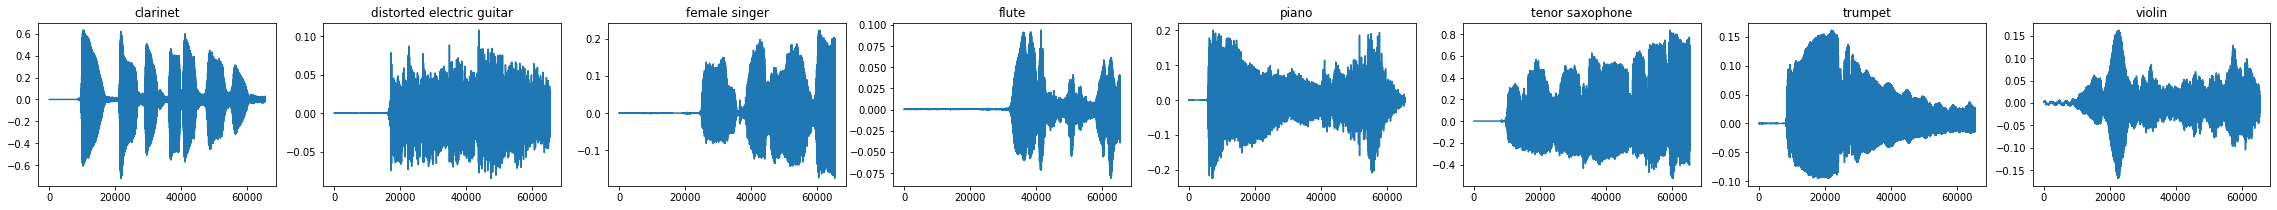

In [ ]:
# Raw-data preprocess analysis parameters
_, fs = medley_solos_db_data[medley_solos_db_ids[0]].audio

num_instruments = len(instrument_dict.keys())
print("Plot waveforms of random samples of each instrument type:")
plt.figure(1, figsize=(5 * num_instruments, 3))
file_ind_inlist = 0 # Let's take the first file in the list for sample plots
for i, instrument in enumerate(instrument_dict.keys()):
    sample_file = instrument_dict[instrument][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_instruments,(i+1))
    plt.plot(x)
    plt.title(instrument)

## Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

We would like to investigate the option of splitting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 # Threshold expressed as ratio with respect to the maximum value

# Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition

def split_file(filename, params):

    '''
    Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];

    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    # Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1

    # Setting segment boundaries
    # Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)

    # Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize

    # Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize

    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


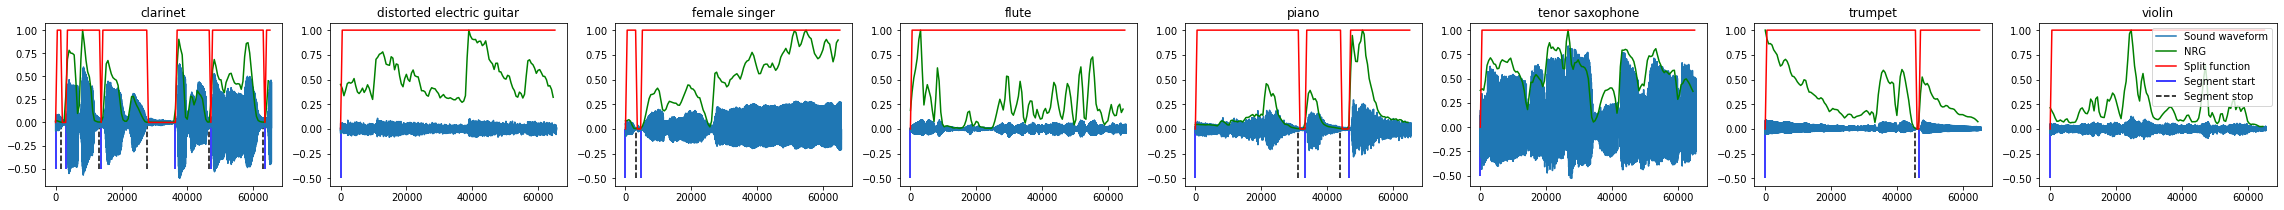

In [ ]:
# Code for plotting in order to check the split decisions

num_instruments = len(instrument_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_instruments, 3))
    for i, instrument in enumerate(instrument_dict.keys()):
        sample_file = instrument_dict[instrument][file_ind_inlist]
        x, NRG, split_decision_func, start_indexes, stop_indexes = split_file(sample_file, params)
        
        # Plotting functions
        plt.subplot(1, num_instruments, (i+1))
        plt.title(instrument)
        plt.plot(x, label='Sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label='NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label='Split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");

In [ ]:
main_data_dir = 'sample_data'
if not os.path.exists(main_data_dir): # Creating the directory
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir): # Creating the directory
    os.mkdir(segments_dir)

segment_files = []
for instrument_name, files in instrument_dict.items():
    for sample_file in files:
        # Get file id
        instrument_id =  sample_file.split('__')[-1].split('.')[0]
        # Join instrument key to file name
        filename = os.path.join(segments_dir, instrument_id + '_' + instrument_name + '.wav')
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        # Crop segments
        for start, stop in zip(start_indexes, stop_indexes):
            x_seg = x[start: stop]
            # Final check for amplitude to avoid silent segments selection due to noise in split function
            if(np.max(np.abs(x_seg)) > 0.05):
                # Amplitude normalisation
                x_seg = x_seg / np.max(np.abs(x_seg))
                filename = os.path.join(segments_dir, instrument_id + '_' + instrument_name + '.wav')
                ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                segment_files.append(filename)

print(len(segment_files),'segment files created')

## Feature extraction 

We will be using [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html)

In [ ]:
# scalar_lowlevel_descriptors = [] is a list of low-level descriptors which are represented with a single scalar value
scalar_lowlevel_descriptors = ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlevel.loudness_ebu128.momentary.mean', 'lowlevel.loudness_ebu128.momentary.stdev', 'lowlevel.loudness_ebu128.short_term.mean', 'lowlevel.loudness_ebu128.short_term.stdev', 'lowlevel.melbands_crest.mean', 'lowlevel.melbands_crest.stdev', 'lowlevel.melbands_flatness_db.mean', 'lowlevel.melbands_flatness_db.stdev', 'lowlevel.melbands_kurtosis.mean', 'lowlevel.melbands_kurtosis.stdev', 'lowlevel.melbands_skewness.mean', 'lowlevel.melbands_skewness.stdev', 'lowlevel.melbands_spread.mean', 'lowlevel.melbands_spread.stdev', 'lowlevel.pitch_salience.mean', 'lowlevel.pitch_salience.stdev', 'lowlevel.silence_rate_20dB.mean', 'lowlevel.silence_rate_20dB.stdev', 'lowlevel.silence_rate_30dB.mean', 'lowlevel.silence_rate_30dB.stdev', 'lowlevel.silence_rate_60dB.mean', 'lowlevel.silence_rate_60dB.stdev', 'lowlevel.spectral_centroid.mean', 'lowlevel.spectral_centroid.stdev', 'lowlevel.spectral_complexity.mean', 'lowlevel.spectral_complexity.stdev', 'lowlevel.spectral_decrease.mean', 'lowlevel.spectral_decrease.stdev', 'lowlevel.spectral_energy.mean', 'lowlevel.spectral_energy.stdev', 'lowlevel.spectral_energyband_high.mean', 'lowlevel.spectral_energyband_high.stdev', 'lowlevel.spectral_energyband_low.mean', 'lowlevel.spectral_energyband_low.stdev', 'lowlevel.spectral_energyband_middle_high.mean', 'lowlevel.spectral_energyband_middle_high.stdev', 'lowlevel.spectral_energyband_middle_low.mean', 'lowlevel.spectral_energyband_middle_low.stdev', 'lowlevel.spectral_entropy.mean', 'lowlevel.spectral_entropy.stdev', 'lowlevel.spectral_flux.mean', 'lowlevel.spectral_flux.stdev', 'lowlevel.spectral_kurtosis.mean', 'lowlevel.spectral_kurtosis.stdev', 'lowlevel.spectral_rms.mean', 'lowlevel.spectral_rms.stdev', 'lowlevel.spectral_rolloff.mean', 'lowlevel.spectral_rolloff.stdev', 'lowlevel.spectral_skewness.mean', 'lowlevel.spectral_skewness.stdev', 'lowlevel.spectral_spread.mean', 'lowlevel.spectral_spread.stdev', 'lowlevel.spectral_strongpeak.mean', 'lowlevel.spectral_strongpeak.stdev', 'lowlevel.zerocrossingrate.mean', 'lowlevel.zerocrossingrate.stdev']

Running musicextractor for all files, keeping a subset of features, writing to an output file: data_lab1_oriol_colome.csv

In [ ]:
# Extracting features and writing in data_lab1_oriol_colome.csv file in the "segments" folder
# Each line in the data_lab1_oriol_colome.csv file represents a sample with features and the class information as the last element

data_file = 'data_lab1_oriol_colome.csv'
file_count = 0

with open(data_file, 'w') as writer:
    # Adding column names as the first line in csv
    line_to_write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line_to_write)
    for filename in segment_files:
        file_count +=1
        if file_count % 50 == 0: # Print name of a file every 50 files
            print(file_count, "files processed, current file: ", filename)

        # Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = filename.split('_')[-1].split('.')[0]
        line_to_write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line_to_write)

print("A total of ", file_count, "files processed")

In [ ]:
data_file = 'sample_data/data_lab1_oriol_colome.csv'
# Read data with pandas module
data = pd.read_csv(data_file)

# Plot first five lines of our data_lab1_oriol_colome.csv
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.990684,24.106297,3.192710,0.506871,0.107450,161.866226,82.491280,7.642255,2.072073,0.451642,0.802028,0.264915,0.077969,5.594913,21.708529,3.848567,0.451256,0.084889,38.925365,20.695107,4.499405,1.066034,3.059038,3.206868,5.776778,5.900886,-10.065744,0.0,-10.505781,2.085783,-16.371023,0.0,25.445772,3.234719,0.592698,0.114782,46.060932,16.169821,3.673697,1.296566,...,0.0,1.0,0.0,0.250,0.433013,298.755859,90.934166,2.642857,0.854161,-5.116690e-09,4.757449e-09,0.019836,0.018486,1.616255e-07,1.827202e-07,9.423679e-07,9.026820e-07,0.000041,0.000057,0.019794,0.018449,4.188445,1.027028,0.028946,0.027055,91.171310,45.399414,0.003761,0.002282,305.310059,86.717896,7.797379,2.679085,2150018.250,2100984.25,1.281256,0.908048,0.012469,0.003076,clarinet
1,0.990684,24.106297,3.192710,0.506871,0.107450,161.866226,82.491280,7.642255,2.072073,0.451642,0.802028,0.264915,0.077969,5.594913,21.708529,3.848567,0.451256,0.084889,38.925365,20.695107,4.499405,1.066034,3.059038,3.206868,5.776778,5.900886,-10.065744,0.0,-10.505781,2.085783,-16.371023,0.0,25.445772,3.234719,0.592698,0.114782,46.060932,16.169821,3.673697,1.296566,...,0.0,1.0,0.0,0.250,0.433013,298.755859,90.934166,2.642857,0.854161,-5.116690e-09,4.757449e-09,0.019836,0.018486,1.616255e-07,1.827202e-07,9.423679e-07,9.026820e-07,0.000041,0.000057,0.019794,0.018449,4.188445,1.027028,0.028946,0.027055,91.171310,45.399414,0.003761,0.002282,305.310059,86.717896,7.797379,2.679085,2150018.250,2100984.25,1.281256,0.908048,0.012469,0.003076,clarinet
2,0.990684,24.106297,3.192710,0.506871,0.107450,161.866226,82.491280,7.642255,2.072073,0.451642,0.802028,0.264915,0.077969,5.594913,21.708529,3.848567,0.451256,0.084889,38.925365,20.695107,4.499405,1.066034,3.059038,3.206868,5.776778,5.900886,-10.065744,0.0,-10.505781,2.085783,-16.371023,0.0,25.445772,3.234719,0.592698,0.114782,46.060932,16.169821,3.673697,1.296566,...,0.0,1.0,0.0,0.250,0.433013,298.755859,90.934166,2.642857,0.854161,-5.116690e-09,4.757449e-09,0.019836,0.018486,1.616255e-07,1.827202e-07,9.423679e-07,9.026820e-07,0.000041,0.000057,0.019794,0.018449,4.

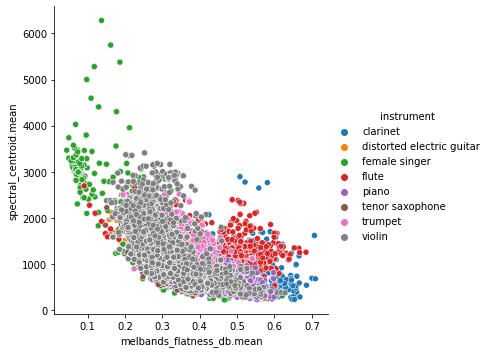

In [ ]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", data = data)

### Preprocessing of the features


In [ ]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:int(len(scalar_lowlevel_descriptors))] = min_max_scaler.fit_transform(data.iloc[:,:int(len(scalar_lowlevel_descriptors))].values)

In [ ]:
# Checking if our data is balanced (if not, we will balance it to prevent our model to be baised)
data_modif.instrument.value_counts()

violin                       3391
flute                        2433
piano                        2291
female singer                1826
trumpet                      1172
clarinet                     1129
tenor saxophone               460
distorted electric guitar     209
Name: instrument, dtype: int64

In [ ]:
min_number = data_modif.instrument.value_counts()['distorted electric guitar'] # 209

violin_data = data_modif[data_modif.instrument == 'violin'].sample(n = min_number)
flute_data = data_modif[data_modif.instrument == 'flute'].sample(n = min_number)
piano_data = data_modif[data_modif.instrument == 'piano'].sample(n = min_number)
female_singer_data = data_modif[data_modif.instrument == 'female singer'].sample(n = min_number)
trumpet_data = data_modif[data_modif.instrument == 'trumpet'].sample(n = min_number)
clarinet_data = data_modif[data_modif.instrument == 'clarinet'].sample(n = min_number)
tenor_saxophone_data = data_modif[data_modif.instrument == 'tenor saxophone'].sample(n = min_number)
distorted_electric_guitar_data = data_modif[data_modif.instrument == 'distorted electric guitar'].sample(n = min_number)

# Merging after downsampling
data_modif = pd.concat([violin_data, flute_data, piano_data, female_singer_data, trumpet_data, clarinet_data, tenor_saxophone_data, distorted_electric_guitar_data])

# Checking the balance again
data_modif.instrument.value_counts()

violin                       209
flute                        209
piano                        209
female singer                209
trumpet                      209
clarinet                     209
tenor saxophone              209
distorted electric guitar    209
Name: instrument, dtype: int64

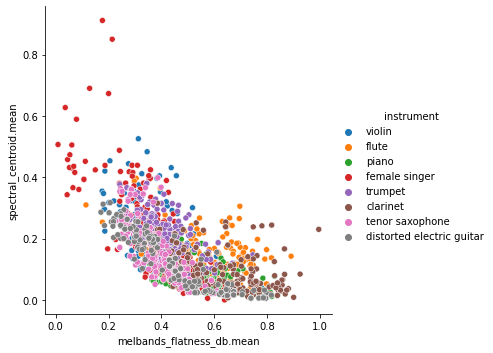

In [ ]:
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", data = data_modif)

## Supervised learning approach (Support Vector Machines)

In [ ]:
# Input values put in a matrix, there are "int(len(scalar_lowlevel_descriptors))" features
X = data_modif.iloc[:,:int(len(scalar_lowlevel_descriptors))].values 

# Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)  # Convert to categorical data
y = np.array(data_modif.instrument.cat.codes)  # Create label encoded outputs

# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [1.00000000e+00 3.29299960e-01 3.20488827e-01 4.05242666e-01
 3.11138630e-01 6.46276746e-04 7.21000286e-04 3.94462022e-01
 1.93865234e-02 2.65298639e-01 1.56462059e-01 6.71514707e-01
 3.23464558e-01 2.92769567e-01 2.64495902e-01 3.47382801e-01
 3.46280216e-01 2.46065104e-01 7.68339415e-03 1.55999604e-02
 3.23732457e-01 1.30034581e-01 2.85690088e-01 1.66279104e-01
 1.35237642e-02 1.25012719e-02 7.29707604e-01 0.00000000e+00
 7.58575962e-01 8.30315492e-02 6.11128613e-01 0.00000000e+00
 3.70219533e-01 2.99676979e-01 3.87159417e-01 2.83546765e-01
 5.12433216e-03 1.70637288e-03 4.73428895e-01 3.28619488e-02
 1.38285025e-01 7.16750343e-02 6.69561686e-01 3.59484963e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.97044338e-01 7.55479336e-01 1.45323624e-01 1.31328779e-01
 1.73009694e-01 1.81149241e-01 8.95354932e-01 7.74277802e-02
 1.09946196e-01 7.98156346e-02 4.40893754e-04 6.49877713e-04
 1.12789938e-06 6.25826866e-07 1.03827211e-01 6.915743

In [ ]:
# Let's split the data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check the sizes of the input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ", y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ", y_test.shape)

Size of train features matrix:  (1120, 84) , Size of train output vector:  (1120,)
Size of test features matrix:  (552, 84) , Size of test output vector:  (552,)


In [ ]:
# Define and train the model
from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit the model with training data
clf.fit(X_train, y_train)

# Predict the classes of test samples
y_pred = clf.predict(X_test)

In [ ]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False, False,  True,
        True, False, False, False, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False,  True, False,
        True,  True,

In [ ]:
# Data is balanced, so we can use "accuracy" as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.7717391304347826


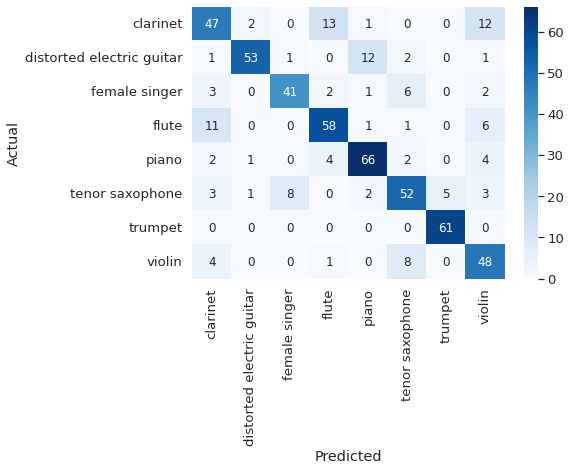

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'

plt.figure(figsize = (7, 5))

sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);